# A notebook for testing statsmodels package

GLM is best implemented by the python package statsmodels. This is a simple notebook that generates some toy data that allows for testing different functionalities of the package before applying it to neural data.

---
# Setup

In [1]:
# @title imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# @title helper functions
def generate_toy_data():
    # Generate sample data
    #np.random.seed(42)
    n_samples = 400

    # Generate feedback (0 or 1)
    feedback = np.random.choice([0, 1], size=n_samples)

    # Generate choice (A, B, or C)
    choice = np.random.choice(['A', 'B', 'C'], size=n_samples)

    # Generate firing rate
    base_rate = 10
    feedback_effect = {'A': 5, 'B': 0, 'C': 0}
    choice_effect = {'A': 0, 'B': 0, 'C': 0}
    noise = np.random.normal(0, 0.5, n_samples)

    firing_rate = []
    for i in range(n_samples):
        firing_rate.append(base_rate + feedback_effect[choice[i]] * feedback[i] + choice_effect[choice[i]] + noise[i])
    firing_rate = np.array(firing_rate)

    # Create DataFrame
    df = pd.DataFrame({
        'firing_rate': firing_rate,
        'feedback': feedback,
        'choice': choice
    })
    
    return df

def add_interaction_terms(df):
    # add dummy variables for choice (keep choice as well)
    df['C_A'] = (df['choice'] == 'A').astype(int)
    df['C_B'] = (df['choice'] == 'B').astype(int)
    df['C_C'] = (df['choice'] == 'C').astype(int)

    # add mixed terms of feedback and choice, name them as A_fb, B_fb, C_fb
    df['A_fb'] = df['C_A'] * df['feedback']
    df['B_fb'] = df['C_B'] * df['feedback']
    df['C_fb'] = df['C_C'] * df['feedback']
    
    return df

In [3]:
# @title plotting functions
def visualize_data(df):
    # show feedback effect
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    
    ax = axs[0]
    colors = {'0': 'tab:red', '1': 'tab:green'}
    sns.boxplot(x='feedback', y='firing_rate', data=df, ax=ax, palette=colors)
    ax.set_title('Firing Rate by Choice and Feedback')
    
    ax = axs[1]
    sns.boxplot(x='choice', y='firing_rate', data=df, ax=ax)
    ax.set_title('Firing Rate by Choice and Feedback')
    
    ax = axs[2]
    colors = {0: 'tab:red', 1: 'tab:green'}
    sns.boxplot(x='choice', y='firing_rate', hue='feedback', data=dataset, ax=ax, palette=colors)
    ax.set_title('Firing Rate by Choice and Feedback')

    plt.tight_layout()
    plt.show()
    
    # Effect of feedback (t-test)
    feedback_0 = df[df['feedback'] == 0]['firing_rate']
    feedback_1 = df[df['feedback'] == 1]['firing_rate']
    t_stat, p_value = stats.ttest_ind(feedback_0, feedback_1)
    print(f"T-test result: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

    # Effect of choice (ANOVA)
    choice_groups = [group for _, group in df.groupby('choice')['firing_rate']]
    f_stat, p_value = stats.f_oneway(*choice_groups)
    print(f"One-way ANOVA result: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")



---
# Section 1: Generate toy data

In [4]:
# generate toy data
dataset = generate_toy_data()
#dataset = add_interaction_terms(dataset)
dataset

,firing_rate,feedback,choice
0,9.869734,0,A
1,9.200380,1,B
2,14.441902,1,A
3,10.544565,1,B
4,10.241330,0,A
...,...,...,...
395,10.738385,0,A
396,9.699234,0,C
397,10.442148,0,A
398,10.513370,1,B


## Show toy data

/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_11572/276579611.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='feedback', y='firing_rate', data=df, ax=ax, palette=colors)


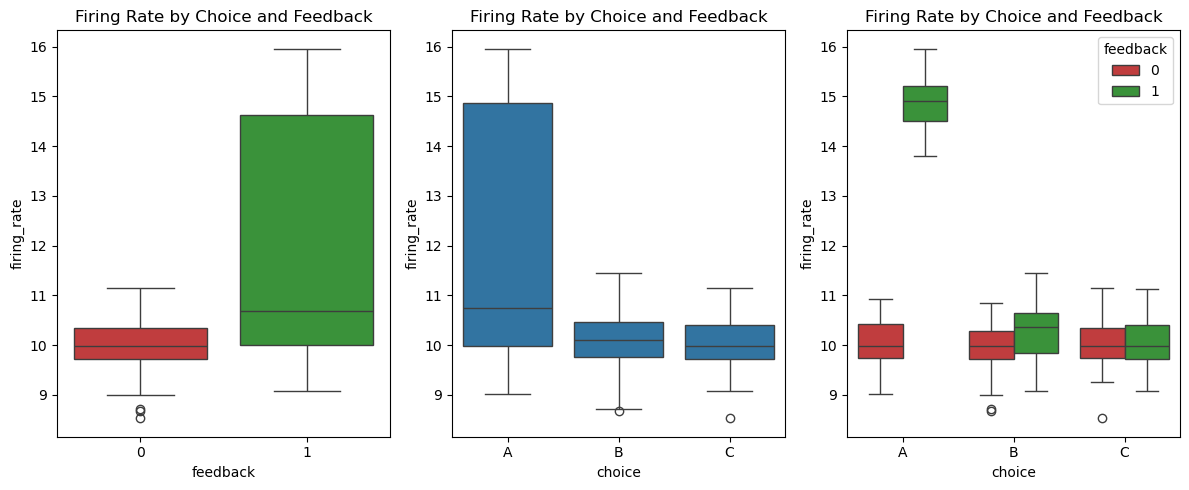

T-test result: t-statistic = -11.5029, p-value = 0.0000
One-way ANOVA result: F-statistic = 94.3178, p-value = 0.0000


In [5]:
visualize_data(dataset)

---
# Section 2: Fit a GLM model

In [6]:
# add interaction terms
dataset = add_interaction_terms(dataset)

In [7]:
# Two-way ANOVA / Linear Regression with interaction
model1 = ols('firing_rate ~ C(feedback) + C(choice) + C(feedback):C(choice)', data=dataset).fit()

# firing_rate = β0 + β1*feedback + β2*choice_B + β3*choice_C + β4*(feedback*choice_B) + β5*(feedback*choice_C) + ε
reference = 'C'
if reference == 'A':
    model2 = ols('firing_rate ~ feedback + C_B + C_C + B_fb + C_fb', data=dataset).fit()
elif reference == 'B':
    model2 = ols('firing_rate ~ feedback + C_A + C_C + A_fb + C_fb', data=dataset).fit()
elif reference == 'C':
    model2 = ols('firing_rate ~ feedback + C_A + C_B + A_fb + B_fb', data=dataset).fit()

# Print model summary
print("\nRegression Model of built in two-way ANOVA:")
print(model1.summary())

print("\nRegression Model of manual two-way ANOVA:")
print(model2.summary())



Regression Model of built in two-way ANOVA:
                            OLS Regression Results                            
Dep. Variable:            firing_rate   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     1041.
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          1.74e-224
Time:                        10:09:18   Log-Likelihood:                -292.08
No. Observations:                 400   AIC:                             596.2
Df Residuals:                     394   BIC:                             620.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [8]:
from scipy.stats import f_oneway

# Perform post-hoc analysis
feedback_types = dataset['feedback'].unique()
target_types = dataset['choice'].unique()

results = []
for target in target_types:
    target_data = dataset[dataset['choice'] == target]
    feedback_groups = [target_data[target_data['feedback'] == ft]['firing_rate'] for ft in feedback_types]
    
    # One-way ANOVA for feedback effect within this target
    f_statistic, p_value = f_oneway(*feedback_groups)
    
    results.append({
        'choice': target,
        'p_value': p_value,
        'signif': p_value < 0.05
    })

df_anova = pd.DataFrame(results)
df_anova

,choice,p_value,signif
0,A,8.901121e-105,True
1,B,6.714288e-03,True
2,C,5.716524e-01,False
